In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery, MultiWindowQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from dotenv import load_dotenv
import torch
from torch import nn
import torch.nn.functional as F
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import pickle
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from lib.constants import AMINO_ACID_MAP, AMINO_ACID_MAP_INV
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'

In [ ]:
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'
# casp_protein_ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
# pdb_codes = ['6T1Z', '7UM1', '7D2O', '7CN6', '7W6B', '7ABW', '6Y4F', '6POO', '6YJ1', '6YA2', '6UV6', '6VQP']
pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir()]
winsizes = [4,5,6,7]
outdir = Path('ml_samples/kde2')
outdir.mkdir(exist_ok=True, parents=True)
n_matches = defaultdict(list)
# pdb_codes = [pdb_codes[0]]
for id in pdb_codes:
    # if (outdir / f'{id}.pt').exists():
    #     continue
    try:
        da = MultiWindowQuery(id, winsizes, PDBMINE_URL, PROJECT_DIR)
        # da.compute_structure()
        da.load_results()
    except FileNotFoundError as e:
        print(e)
        continue
    if da.af_phi_psi is None:
        continue
    seqs = pd.merge(
        da.xray_phi_psi[['seq_ctxt', 'res', 'phi', 'psi']], 
        da.af_phi_psi[['seq_ctxt', 'phi', 'psi']], 
        on='seq_ctxt', suffixes=('', '_af')
    ).rename(columns={'seq_ctxt': 'seq'})
    if seqs.shape[0] == 0:
        print('No sequences for', id)
        continue

    print(seqs.shape, seqs.seq.nunique())
    X = []
    y = []
    x_res = []
    af_phi_psi = []
    af_confs = []
    for i,row in tqdm(seqs.iterrows()):
        kdepeaks = []
        if np.isnan(row.phi) or np.isnan(row.psi) or np.isnan(row.phi_af) or np.isnan(row.psi_af):
            print('NaNs for', row.seq)
            continue
        af_conf = da.af_phi_psi.loc[da.af_phi_psi.seq_ctxt == row.seq, 'conf'].values[0]
        for q in da.queries:
            inner_seq = q.get_subseq(row.seq)
            # matches = q.results[q.results.seq == inner_seq][['seq', 'phi', 'psi']]
            matches = q.results[q.results.seq == inner_seq]
            if matches.shape[0] < 2:
                kdepeaks.append(torch.zeros(2))
                continue
            phi = matches.phi.values
            psi = matches.psi.values
            x = np.stack([phi, psi])
            try:
                kde = gaussian_kde(x, bw_method=0.5)
                phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 180), np.linspace(-180, 180, 180))
                grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
                probs = kde(grid).reshape(phi_grid.shape)
                kdepeak = grid[:,probs.argmax()]
                kdepeaks.append(torch.tensor(kdepeak))
            except np.linalg.LinAlgError as e:
                kdepeaks.append(torch.zeros(2))
        kdepeaks = torch.stack(kdepeaks)
        if torch.sum(kdepeaks) == 0:
            print('No matches for', row.seq)
            continue

        X.append(kdepeaks)
        y.append(torch.tensor([row.phi, row.psi]))
        x_res.append(AMINO_ACID_MAP[row.res])
        af_phi_psi.append(torch.tensor([row.phi_af, row.psi_af]))
        af_confs.append(af_conf)
    if len(X) == 0:
        print('No matches for', id)
        continue
    X = torch.stack(X)
    y = torch.stack(y)
    x_res = F.one_hot(torch.tensor(x_res).to(torch.int64), num_classes=20)
    af_phi_psi = torch.stack(af_phi_psi)
    af_conf = torch.tensor(af_confs)
    torch.save((X, x_res, af_phi_psi, af_conf, y), outdir / f'{id}.pt')

In [3]:
class ProteinDatasetKDE(Dataset):
    def __init__(self, id, path):
        self.id = id
        self.path = path

        self.X, self.xres, self.af, self.conf, self.y = torch.load(self.path / f'{id}.pt')
        self.X, self.xres, self.af, self.conf, self.y = self.X.float(), self.xres.float(), self.af.float(), self.conf.float(), self.y.float()
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.xres[i], self.af[i], self.conf[i], self.y[i]

class WindowedProteinDataset(Dataset):
    def __init__(self, id, path, winsize):
        self.id = id
        self.path = path
        self.winsize = winsize
        self.X, self.xres, self.af, self.y = torch.load(self.path / f'{id}.pt')
        self.X, self.xres, self.af, self.y = self.X.float(), self.xres.float(), self.af.float(), self.y.float()
    def __len__(self):
        return self.X.shape[0] - self.winsize + 1
    
    def __getitem__(self, i):
        return self.X[i:i+self.winsize], self.xres[i:i+self.winsize], self.af[i:i+self.winsize], self.y[i+self.winsize-1]

In [4]:
path = Path('ml_samples/kde_v2')
samples = [f.stem for f in path.iterdir()]

from lib.retrieve_data import retrieve_target_list
ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
targetlist = retrieve_target_list()
skip = [targetlist.loc[id, 'pdb_code'].upper() for id in ids]
samples = sorted(list(set(samples) - set(skip)))

train, test = train_test_split(samples, test_size=0.35, random_state=42)
torch.save((train, test), 'ml_runs/split.pt')
# train, test = to ch.load('ml_data/split.pt')
train_dataset = ConcatDataset([ProteinDatasetKDE(s, path) for s in train])
test_dataset = ConcatDataset([ProteinDatasetKDE(s, path) for s in test])
trainloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# winsize=15
# windowed_train_dataset = ConcatDataset([WindowedProteinDataset(s, path, winsize) for s in train])
# windowed_test_dataset = ConcatDataset([WindowedProteinDataset(s, path, winsize) for s in test])
# windowed_trainloader = DataLoader(windowed_train_dataset, batch_size=512, shuffle=True)
# windowed_testloader = DataLoader(windowed_test_dataset, batch_size=512, shuffle=False)

len(train_dataset), len(test_dataset), len(train_dataset) + len(test_dataset)

(68502, 38124, 106626)

In [5]:
X, xres, af, conf, y = next(iter(trainloader))

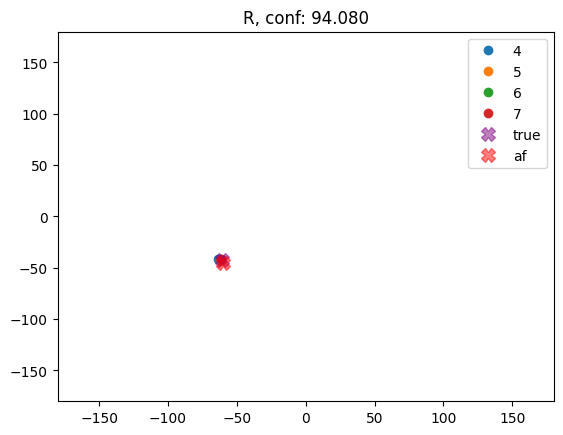

In [6]:
def plot(Xp, y, i, logits=None, logits2=None, res=None, af=None):
    Xp = Xp.cpu().clone().detach()
    y = y.cpu().clone().detach()
    plt.plot(Xp[i, 0, 0], Xp[i, 0, 1], 'o', label='4')
    plt.plot(Xp[i, 1, 0], Xp[i, 1, 1], 'o', label='5')
    plt.plot(Xp[i, 2, 0], Xp[i, 2, 1], 'o', label='6')
    plt.plot(Xp[i, 3, 0], Xp[i, 3, 1], 'o', label='7')
    
    plt.plot(y[i,0],y[i,1], 'X', label='true', color='purple',  markersize=10, alpha=0.5)
    if res is not None:
        res = res.cpu().clone().detach()
        plt.title(f'{AMINO_ACID_MAP_INV[res[i].argmax().item()]}, conf: {conf[i]:.03f}')
    if af is not None:
        af = af.cpu().clone().detach()
        plt.plot(af[i,0],af[i,1], 'X', label='af', color='red', markersize=10, alpha=0.5)
    if logits is not None:
        logits = logits.cpu().clone().detach()
        plt.plot(logits[i,0].detach(),logits[i,1].detach(), 'X', label='pred', color='black', markersize=10)
    if logits2 is not None:
        logits2 = logits2.cpu().clone().detach()
        plt.plot(logits2[i,0].detach(),logits2[i,1].detach(), 'X', label='pred2', color='orange', markersize=10)
    plt.legend()
    plt.xlim(-180,180)
    plt.ylim(-180,180)
plot(X,y, 16, res=xres, af=af)

In [7]:
def save_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    torch.save(model.state_dict(), path)
def load_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    model.load_state_dict(torch.load(path))
    return model

In [10]:
class KDENet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(31, 16)
        self.ln1 = nn.LayerNorm(16, elementwise_affine=False)
        self.l2 = nn.Linear(16, 32)
        self.ln2 = nn.LayerNorm(32, elementwise_affine=False)
        # self.l3 = nn.Linear(32, 64)
        # self.ln3 = nn.LayerNorm(64, elementwise_affine=False)
        self.out = nn.Linear(32, 2)
    
    def forward(self, X, xres, af, conf):
        x = torch.hstack([X.flatten(1), af, xres, conf.unsqueeze(-1)])
        # x = torch.hstack([X.flatten(1), torch.zeros(af.shape[0], 2).to(af.device), xres, conf.unsqueeze(-1)])
        x = F.relu(self.l1(x))
        x = self.ln1(x)
        x = F.relu(self.l2(x))
        x = self.ln2(x)
        # x = F.relu(self.l3(x))
        # x = self.ln3(x)
        x = self.out(x)
        return x

class AngleMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        def diff(x1, x2):
            d = torch.abs(x1 - x2)
            d = torch.minimum(d, 360-d)
            return d
        phi_diff = diff(x[:,0], y[:,0]).unsqueeze(1)
        psi_diff = diff(x[:,1], y[:,1]).unsqueeze(1)
        return torch.mean(torch.hstack([phi_diff, psi_diff])**2)
    
device = 'cuda:0'
model = nn.DataParallel(KDENet()).to(device)
criterion = AngleMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
sum([p.numel() for p in model.parameters()])

1122

In [11]:
X,xres,af,conf,y = next(iter(trainloader))
print(X.shape, xres.shape, af.shape, y.shape)
model(X.to(device),xres.to(device),af.to(device),conf.to(device)).shape

torch.Size([512, 4, 2]) torch.Size([512, 20]) torch.Size([512, 2]) torch.Size([512, 2])


torch.Size([512, 2])

In [ ]:
# LN: 312,346

In [12]:
train_losses = []
test_losses = []
lowest_test_loss = float('inf')
writer = SummaryWriter('tensorboard')
for epoch in (pbar := tqdm(range(1500))):
    losses = []
    model.train()
    for X,xres,af,conf,y in trainloader:
        X,xres,af,conf,y = X.to(device), xres.to(device), af.to(device), conf.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X, xres, af, conf)
        if logits.isnan().sum() > 0:
            raise ValueError('nan')
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    model.eval()
    for X,xres,af,conf,y in testloader:
        with torch.no_grad():
            X,xres,af,conf,y = X.to(device), xres.to(device), af.to(device), conf.to(device), y.to(device)
            logits = model(X, xres, af, conf)
            loss = criterion(logits, y)
            losses.append(loss.item())
    test_losses.append(sum(losses) / len(losses))
    if test_losses[-1] < lowest_test_loss:
        lowest_test_loss = test_losses[-1]
        save_model(model, 'ml_runs/best_model.pt')
    writer.add_scalars('Loss', {
        'train': train_losses[-1],
        'test': test_losses[-1]
    }, epoch)
    writer.flush()

    pbar.set_postfix({'train_loss': train_losses[-1], 'test_loss': test_losses[-1]})
writer.close()

  0%|          | 0/1500 [00:00<?, ?it/s]

 25%|██▍       | 368/1500 [08:13<25:17,  1.34s/it, train_loss=927, test_loss=1e+3]       


KeyboardInterrupt: 

In [8]:
class KDELSTMNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.h = 16
        self.mlph = 128
        self.lstm = nn.LSTM(30, self.h, batch_first=True, bidirectional=False, num_layers=8)
        self.ln1 = nn.LayerNorm(self.h, elementwise_affine=False)
        self.hidden1 = nn.Linear(self.h, self.mlph)
        self.ln2 = nn.LayerNorm(self.mlph, elementwise_affine=False)
        self.hidden2 = nn.Linear(self.mlph, 2)
    
    def forward(self, X, xres, af):
        x = torch.concat([X.flatten(2), af, xres], dim=2)
        x, (h,c) = self.lstm(x)
        x = F.relu(self.ln1(x[:,-1]))

        x = F.relu(self.ln2(self.hidden1(x)))
        x = self.hidden2(x)
        return x
class AngleMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        def diff(x1, x2):
            d = torch.abs(x1 - x2)
            d = torch.minimum(d, 360-d)
            return d
        phi_diff = diff(x[:,0], y[:,0]).unsqueeze(1)
        psi_diff = diff(x[:,1], y[:,1]).unsqueeze(1)
        return torch.mean(torch.hstack([phi_diff, psi_diff])**2)

device = 'cuda:0'
# model = nn.DataParallel(KDELSTMNet()).to(device)
model = KDELSTMNet().to(device)
criterion = AngleMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
sum([p.numel() for p in model.parameters()])

20738

In [42]:
X,xres,af,y = next(iter(windowed_trainloader))
print(X.shape)
model(X.to(device),xres.to(device),af.to(device)).shape

torch.Size([512, 15, 4, 2])


torch.Size([512, 2])

In [43]:
train_losses = []
test_losses = []
lowest_test_loss = float('inf')
writer = SummaryWriter('tensorboard2')
for epoch in (pbar := tqdm(range(1500))):
    losses = []
    model.train()
    for X,xres,af,y in windowed_trainloader:
        X,xres,af,y = X.to(device), xres.to(device), af.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X, xres, af)
        if logits.isnan().sum() > 0:
            raise ValueError('nan')
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    model.eval()
    for X,xres,af,y in windowed_testloader:
        with torch.no_grad():
            X,xres,af,y = X.to(device), xres.to(device), af.to(device), y.to(device)
            logits = model(X, xres, af)
            loss = criterion(logits, y)
            losses.append(loss.item())
    test_losses.append(sum(losses) / len(losses))
    if test_losses[-1] < lowest_test_loss:
        lowest_test_loss = test_losses[-1]
        save_model(model, 'ml_data/best_model.pt')
    writer.add_scalars('Loss', {
        'train': train_losses[-1],
        'test': test_losses[-1]
    }, epoch)
    writer.flush()

    pbar.set_postfix({'train_loss': train_losses[-1], 'test_loss': test_losses[-1]})
writer.close()

100%|██████████| 1500/1500 [13:06<00:00,  1.91it/s, train_loss=396, test_loss=674]      


In [11]:
model = KDENet()
model.load_state_dict(torch.load('ml_runs/best_model.pt', map_location='cpu'))
# load_model(model, 'ml_data/best_model_kde_64-64_390.pt')

<All keys matched successfully>

In [ ]:
weights = model.l1.weight.data.numpy()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(weights.T[:10], ax=ax)
yticklabels = ['4 phi', '4 psi', '5 phi', '5 psi', '6 phi', '6 psi', '7 phi', '7 psi', 'AF phi', 'AF psi']
ax.set_yticklabels(yticklabels)
ax.set_xticks([])
# rotate yticks
plt.yticks(rotation=0);
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(weights.T[10:], ax=ax)
ax.set_yticklabels([AMINO_ACID_MAP_INV[i] for i in range(20)])
ax.set_xticks([])

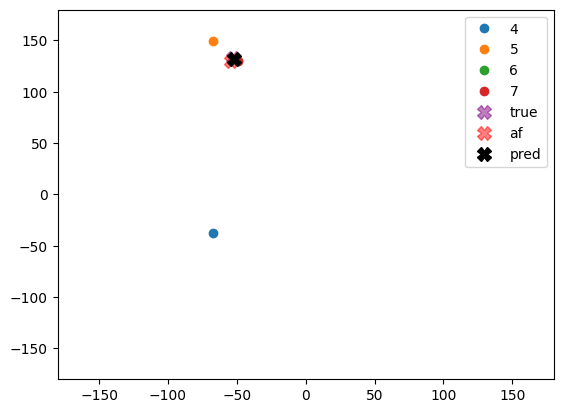

In [16]:
model = model.to(device)
for X,xres,af,conf,y in testloader:
    with torch.no_grad():
        X,xres,af,conf,y = X.to(device), xres.to(device), af.to(device), conf.to(device),y.to(device)
        logits = model(X, xres, af, conf)
    break
plot(X, y, 300, logits, af=af)

In [39]:
def diff(x1, x2):
    d = np.abs(x1 - x2)
    return np.minimum(d, 360-d)

In [23]:
model = nn.DataParallel(KDENet().to(device))
load_model(model, 'ml_runs/best_model.pt')
model.eval()
preds = []
true = []
loss = []

model.eval()
for X,xres,af,conf,y in tqdm(testloader):
    with torch.no_grad():
        X,xres,af,conf,y = X.to(device), xres.to(device), af.to(device), conf.to(device), y.to(device)
        logits = model(X, xres, af, conf)
        lossi = criterion(logits, y)
        loss.append(lossi.item())
        preds.append(logits.cpu().numpy())
        true.append(y.cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)
loss = np.mean(loss)
loss

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:00<00:00, 305.35it/s]


367.3826973470052

In [42]:
af_preds = []
af_loss = []
for X,xres,af,conf,y in tqdm(testloader):
    af_lossi = criterion(af, y)
    af_loss.append(af_lossi.item())
    af_preds.append(af.numpy())
af_preds = np.concatenate(af_preds)
af_loss = np.mean(af_loss)
af_loss

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:00<00:00, 148.45it/s]


405.71266535441083

In [56]:
(-43 - 1062 - 2381 - 4762) / (1 + 32 + 64 + 128)

-36.65777777777778

In [60]:
kdes = []
kde_loss = []
weights = torch.tensor([1,32,64,128])
for X,xres,af,conf,y in tqdm(testloader):
    x = X * weights.unsqueeze(-1)
    x = x.sum(dim=1) / weights.sum()
    kde_lossi = criterion(x, y)
    kde_loss.append(kde_lossi.item())
    kdes.append(x.numpy())
kdes = np.concatenate(kdes)
kde_loss = np.mean(kde_loss)
kde_loss

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:00<00:00, 257.68it/s]


1440.0897444152831

In [170]:
kdes = torch.load('ml_data/kdes.pt')

In [62]:
preds_dist = np.sqrt(diff(preds[:,0], true[:,0])**2 + diff(preds[:,1], true[:,1])**2)
kdes_dist = np.sqrt(diff(kdes[:,0], true[:,0])**2 + diff(kdes[:,1], true[:,1])**2)
# kdes_dist = kdes_dist[~np.isnan(kdes_dist)]
af_dist = np.sqrt(diff(af_preds[:,0], true[:,0])**2 + diff(af_preds[:,1], true[:,1])**2)
print('preds', preds_dist.mean(), preds_dist.std(), preds_dist.sum())
print('kdes', kdes_dist.mean(), kdes_dist.std(), kdes_dist.sum())
print('af', af_dist.mean(), af_dist.std(), af_dist.sum())

preds 13.864162 22.368944 528557.3
kdes 30.230183 44.553772 1152495.5
af 15.3863 24.039232 586587.3


# K-fold

In [74]:
path = Path('ml_samples/kde')
samples = [f.stem for f in path.iterdir()]

from lib.retrieve_data import retrieve_target_list
ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
targetlist = retrieve_target_list()
skip = [targetlist.loc[id, 'pdb_code'].upper() for id in ids]
samples = sorted(list(set(samples) - set(skip)))
samples = np.array(samples)
samples = np.random.choice(samples, len(samples) - len(samples)%10, replace=False)
samples = samples.reshape(10,-1)

train_losses = []
test_losses = []
af_test_losses = []
for k in (pbar := tqdm(range(10))):
    train = samples[np.arange(10) != k].flatten()
    test = samples[k]
    train_dataset = ConcatDataset([ProteinDatasetKDE(s, path) for s in train])
    test_dataset = ConcatDataset([ProteinDatasetKDE(s, path) for s in test])
    trainloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    model = nn.DataParallel(KDENet()).to(device)
    criterion = AngleMSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    lowest_test_loss = float('inf')
    for epoch in range(500):
        model.train()
        losses = []
        for X,xres,af,y in trainloader:
            X,xres,af,y = X.to(device), xres.to(device), af.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X, xres, af)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    train_losses.append(sum(losses) / len(losses))

    losses = []
    af_losses = []
    model.eval()
    for X,xres,af,y in testloader:
        with torch.no_grad():
            X,xres,af,y = X.to(device), xres.to(device), af.to(device), y.to(device)
            logits = model(X, xres, af)
            loss = criterion(logits, y)
            losses.append(loss.item())
            af_losses.append(criterion(af, y).item())
    test_losses.append(sum(losses) / len(losses))
    af_test_losses.append(sum(af_losses) / len(af_losses))
    pbar.set_postfix({'k=': k, 'train_loss': train_losses[-1], 'test_loss': test_losses[-1]})

100%|██████████| 10/10 [49:37<00:00, 297.80s/it, k==9, train_loss=334, test_loss=213]
